<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [3]:
#Import necessary modules for Google Colab to mount Google Drive and authenticate user
from google.colab import drive
from google.colab import auth

#Mount Google Drive and authenticate user to access Google services
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Authenticated


#Load Packages

In [4]:
#Import necessary packages for Google BigQuery and data processing
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

#Install and import the geoip2 package for geolocation
!pip install geoip2
import geoip2.database

#Import additional packages for time management, machine learning, and data scaling
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

fatal: destination path 'CAS_ADS_Final_Project' already exists and is not an empty directory.


# Connect to Big Query and Get Data

In [25]:
#Set up Google BigQuery client with the specified project ID
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)
#Fraud cases - (TC40/Safe -  run the model against Fraud cases only)!

#Query to select fraud and non-fraud cases from the dataset
Query = """
Select distinct * from (
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)
union all
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (
Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id not in (Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)) limit 12869));
"""

#Validation set 2024
#Execute the query and convert the results to a Pandas DataFrame
Query_Results = bigquery_client.query(Query)
Data_Adf = Query_Results.to_dataframe()

#Remove duplicate records based on the 'id' column
Data_Adf = Data_Adf.drop_duplicates(subset=['id'])
Data_Adf

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud
0,2556482,7IOP3psg,ijmnlIUy,500.000000000,428.520000000,5.102.205.105,NaT,None,None,<NA>,...,25,7277,"Counseling Services – Debt, Marriage, and Pers...",2022-11-13 15:51:44+00:00,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,FR
1,2594652,xWmaqrJ8,Th5n3HfY,500.000000000,400.380000000,5.102.205.105,NaT,None,None,<NA>,...,25,7277,"Counseling Services – Debt, Marriage, and Pers...",2022-11-13 15:51:44+00:00,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,FR
2,2554910,cX4KMEw4,xp6cOkIW,1.950000000,1.670000000,88.122.161.130,NaT,None,None,<NA>,...,11,5815,"Digital Goods Media – Books, Movies, Digital a...",2022-11-13 15:45:24+00:00,NaT,<NA>,None,NaT,NaT,FR
3,2558567,WngNZRmF,HaFsD1yx,1.950000000,1.670000000,78.233.70.2,NaT,None,None,<NA>,...,11,5815,"Digital Goods Media – Books, Movies, Digital a...",2022-11-13 15:45:24+00:00,NaT,<NA>,None,NaT,NaT,FR
4,2742652,jBRpxQdG,FRWr5yUK,1.950000000,1.670000000,91.175.56.244,NaT,None,None,<NA>,...,11,5815,"Digital Goods Media – Books, Movies, Digital a...",2022-11-13 15:45:24+00:00,NaT,<NA>,None,NaT,NaT,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79115,9661446,DospQbRi,dczrTUQL,297.000000000,234.990000000,2607:fb91:1610:d23:f0fe:dbaf:680f:d440,2023-10-04 12:42:36+00:00,75284533278358851001715,None,<NA>,...,9,8299,Schools & Educational Services (Not Elsewhere ...,2022-11-13 15:43:58+00:00,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,None
79116,7690062,duwaSarK,2rrl9wVd,67.000000000,53.010000000,2600:1009:b1c3:2ed7:1c85:d96:18a6:649d,2023-03-14 05:20:52+00:00,74595343074000003986289,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,None
79117,7735637,opMNmif2,KMaeTB4T,67.000000000,53.010000000,2601:143:c500:5a0:8d79:ff94:b0f:bd38,2023-03-18 14:25:56+00:00,74595343078000001714291,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,None
79118,7508191,5uAffrtz,TFHYSW7z,67.000000000,53.010000000,2600:8805:3600:a0::f6b9,2023-02-24 15:26:14+00:00,74595343056000009958342,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,None


#Check whether there are any duplicate ID's

In [26]:
duplicate_rows = Data_Adf[Data_Adf.duplicated(subset=['id'])]
duplicate_rows

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud


#Conversion and Creation of Variables

In [27]:
#Function to convert columns to float type
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

#Function to convert columns to string type
def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

#Define columns to be converted to string and float
columns_to_string = ['id']
columns_to_float = ['amount_gbp']

#Convert specified columns to float and string types
convert_float(columns_to_float)
convert_string(columns_to_string)

#Replace 'None' with a placeholder value & map string values to boolean values
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].fillna('Missing')
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].map({'Missing': False, 'FR': True})

#Data Analysis

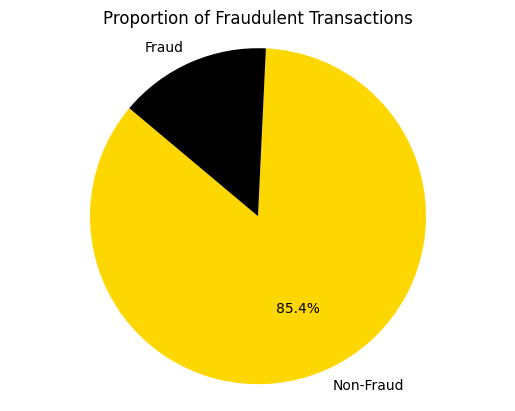

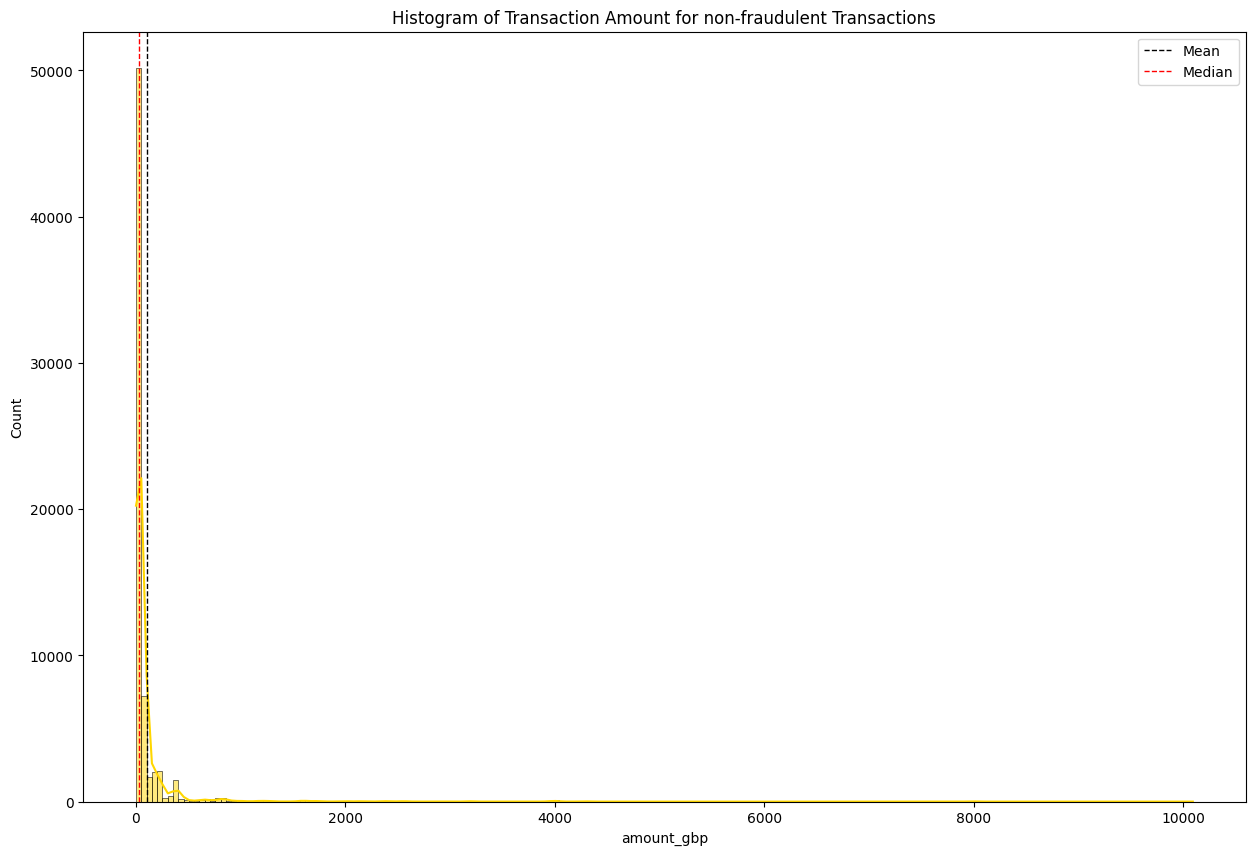

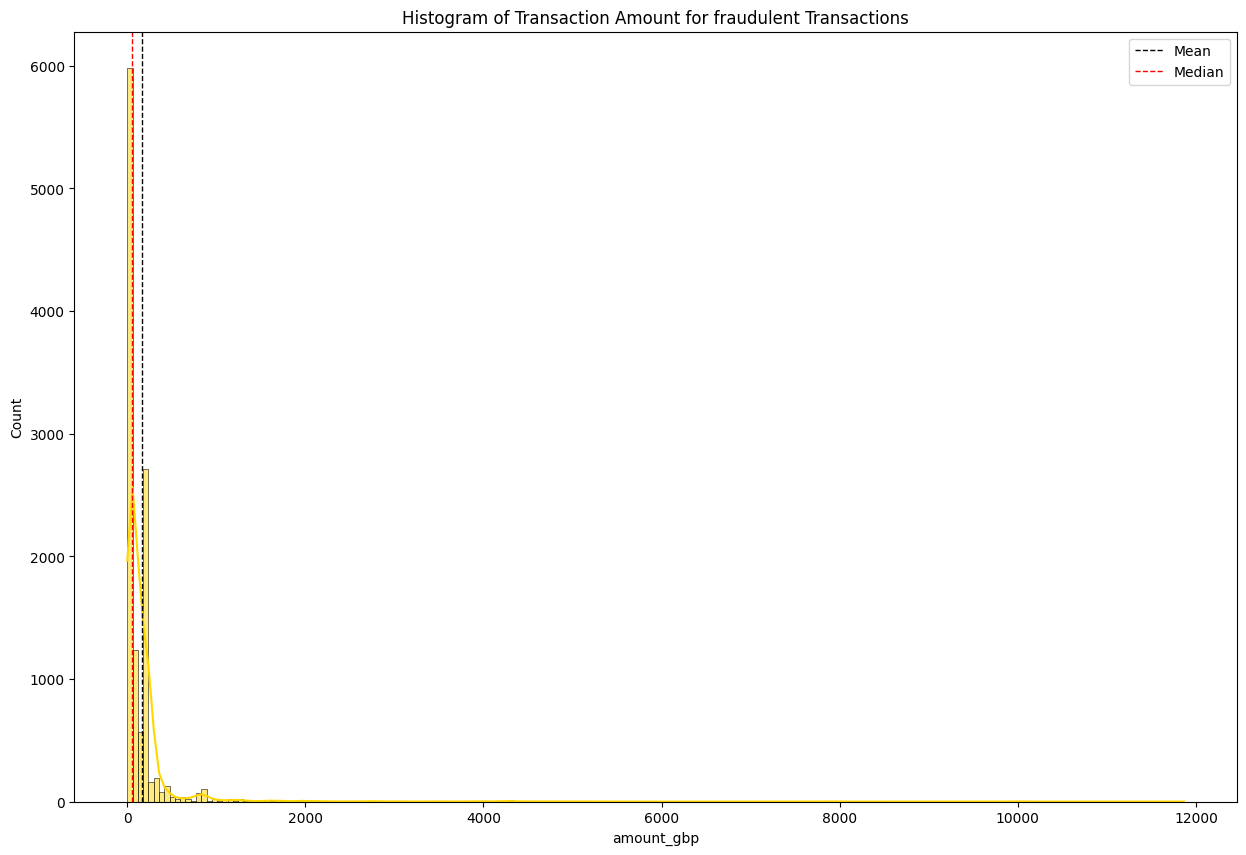

In [32]:
#Visualization of share of fraudulent vs. non-fraudulent transactions (trx) using a pie chart
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check the amount distribution of fraudulent vs. non-fraudulent trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Plotting of histogram of transaction amount for non-fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for non-fraudulent Transactions")
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Plotting of histogram of transaction amount for fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for fraudulent Transactions")
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [34]:
#Calcualte Customer Profile Statistics: mean, median and standard deviation of transaction amount per client
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']

#Calcualte Average Number of trx per day per customer
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge datasets to combine customer profile statistics
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.65,53.65,1.0
1,1058557,53.65,53.65,1.0
2,1058568,157.75,157.75,1.0
3,1058569,157.75,157.75,1.0
4,1058595,37.64,37.64,1.0
...,...,...,...,...
23216,4639214,39.23,39.23,1.0
23217,4640022,31.20,31.20,1.0
23218,4640882,216.18,216.18,1.0
23219,4641465,128.41,128.41,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [35]:
#Function to get country information from an IP address
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

#Read country latitude and longitude data from a CSV file
df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')

In [36]:
#Get Customer Device IP coordinates (country) and use get_country function to get country information
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

#Merge country information with latitude and longitude data
merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

,id,client_id,latitude_ip,longitude_ip
0,2556482,1367674,NaN,NaN
1,2594652,1383637,NaN,NaN
2,2554910,1367044,NaN,NaN
3,2558567,1368634,NaN,NaN
4,2742652,1448921,NaN,NaN
...,...,...,...,...
79111,9661446,3978221,37.09024,-95.712891
79112,7690062,3356665,NaN,NaN
79113,7735637,3371972,37.09024,-95.712891
79114,7508191,3295691,37.09024,-95.712891


In [37]:
#Get customer card issuer bank coordinates (country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()

#Fill NaN values with 0 and rename column for consistency
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)

#Merge country information with latitude and longitude data
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,2556482,1367674,NaN,NaN
1,2594652,1383637,NaN,NaN
2,2554910,1367044,NaN,NaN
3,2558567,1368634,NaN,NaN
4,2742652,1448921,NaN,NaN
...,...,...,...,...
79111,9661446,3978221,37.09024,-95.712891
79112,7690062,3356665,37.09024,-95.712891
79113,7735637,3371972,37.09024,-95.712891
79114,7508191,3295691,37.09024,-95.712891


In [39]:
#Merge country profiles based on ID
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,how = 'left', on='id')

#Select relevant columns and rename them
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns
old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
2556482,1367674,NaN,NaN,NaN,NaN
2594652,1383637,NaN,NaN,NaN,NaN
2554910,1367044,NaN,NaN,NaN,NaN
2558567,1368634,NaN,NaN,NaN,NaN
2742652,1448921,NaN,NaN,NaN,NaN
...,...,...,...,...,...
9661446,3978221,37.09024,-95.712891,37.09024,-95.712891
7690062,3356665,NaN,NaN,37.09024,-95.712891
7735637,3371972,37.09024,-95.712891,37.09024,-95.712891


# Get Transaction Profile (Trx_Profile)

In [40]:
#Function to convert time to seconds
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

#Function to check if a date is a weekend
def is_weekend(date):
    return date.weekday() >= 5

#Function to calculate client spending behavior features over various rolling window sizes of customer transactions
def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)

#Drop unnecessary columns and rename
columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}
Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
2556482,2021-03-30 12:03:56+00:00,1367674,428.52,43436,0,0
2594652,2021-04-06 12:01:32+00:00,1383637,400.38,43292,0,0
2554910,2021-03-30 07:54:38+00:00,1367044,1.67,28478,0,0
2558567,2021-03-30 17:33:03+00:00,1368634,1.67,63183,0,0
2742652,2021-04-30 08:49:41+00:00,1448921,1.67,31781,0,0
...,...,...,...,...,...,...
9661446,2023-10-04 12:42:37+00:00,3978221,234.99,45757,0,0
7690062,2023-03-14 05:20:52+00:00,3356665,53.01,19252,0,0
7735637,2023-03-18 14:25:56+00:00,3371972,53.01,51956,1,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [41]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

#Convert timestamp to datetime without timezone
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and client ID
Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate customer spending behavior features
%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

#Set 'id' column as index and convert it to integer type
Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 2min 26s, sys: 1.78 s, total: 2min 28s
Wall time: 2min 39s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983595,2021-01-01 01:57:17,1058595,37.64,1.0,37.64,1.0,37.64,1.0,37.64
...,...,...,...,...,...,...,...,...,...
11578964,2024-04-29 19:53:08,4639214,39.23,1.0,39.23,1.0,39.23,1.0,39.23
11581002,2024-04-30 06:37:38,4640022,31.20,1.0,31.20,1.0,31.20,1.0,31.20
11584134,2024-04-30 11:50:39,4640882,216.18,1.0,216.18,1.0,216.18,1.0,216.18


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [44]:
#Function to calculate spending behavior features of a brand over various rolling window sizes of customer transactions
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

#Create a new column for fraudulent transaction amounts
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

#Extract relevant columns for Brand Fraud Profile
Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

#Convert timestamp to datetime without timezone
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and brand ID
Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate brand fraud profile features
%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

#Set 'id' column as index and convert it to integer type
Brand_Fraud_Profile.set_index('id',inplace=True)
Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

#Drop the 'amount_gbp_fraud_trx' column
Brand_Fraud_Profile = Brand_Fraud_Profile.drop('amount_gbp_fraud_trx', axis=1)
Brand_Fraud_Profile

CPU times: user 3.09 s, sys: 329 µs, total: 3.09 s
Wall time: 3.24 s


,timestamp,Brands_id,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,
1989686,2021-01-02 18:18:00,1234,1.0,53.65,1.0,53.6500,1.0,53.6500
1999498,2021-01-04 21:42:57,1234,1.0,157.75,2.0,105.7000,2.0,105.7000
2001827,2021-01-05 09:31:50,1234,2.0,105.70,3.0,88.3500,3.0,88.3500
2103691,2021-01-06 21:50:25,1234,1.0,45.64,4.0,77.6725,4.0,77.6725
2121615,2021-01-09 07:47:44,1234,1.0,53.65,5.0,72.8680,5.0,72.8680
...,...,...,...,...,...,...,...,...
11589201,2024-04-30 21:02:30,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589214,2024-04-30 21:04:39,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589322,2024-04-30 21:20:27,851571,0.0,NaN,0.0,NaN,0.0,NaN


In [46]:
abc = Trx_Profile_Rolling.copy()
xyz = Brand_Fraud_Profile.copy()

abc = abc.reset_index(level='id') #Key is id
xyz = xyz.reset_index(level='id') #Key is id

# Convert 'id' column to sets for faster comparison
id_set1 = set(abc['id'])
id_set2 = set(xyz['id'])

# Find missing IDs in df2
missing_ids = id_set1 - id_set2

print("Missing IDs in df2:", missing_ids)


Missing IDs in df2: {11534304, 11533990, 11317449, 11493233, 11533171, 11272535, 11351675, 11319101}


# Get All Dummy Variables (Data_Dummies)

In [47]:
#Creating a copy of the original data frame with the needed columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()

#Extract email domain
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating dummy variables for categorical columns, dropping email column and converting columns to integer type
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

# Set 'id' column as index
Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_CZK,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_RUB,Currency_name_USD,Currency_name_ZAR,...,Companies_name_xShop_OU,Companies_name_xrg3olb_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
2556482,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2594652,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2554910,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2558567,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2742652,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9661446,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
7690062,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
7735637,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# Merge all Datasets into a Single Dataset

In [48]:
#Rest indexs in all dataframes in preparation to merge
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id

In [56]:
#Extract fraud flag column and convert to integer type
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag.loc[:, 'id'] = DF_Flag['id'].astype(int)
DF_Flag.loc[:, 'Is_fraud'] = DF_Flag['Is_fraud'].astype(int)

#Add the previously newly created attributes to the id and fraud flag dataset with a merge
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

##only when Testing With Full Dataset

In [ ]:
#Add the dummies dataset with a merge
DF5 = pd.merge(DF4, Data_Dummies, how='left', on='id')

##only when Testing Without Profiles

In [ ]:
#Merge the previously newly created dummy variables to the id and fraud flag dataset with a merge
DF_x = pd.merge(Data_Dummies, DF_Flag, how='left', on='id')

# Balancing Dataset

In [ ]:
#Selecting subset with fraudulent and non-fraudulent trx and removing duplicate rows based on the 'id' column
#For Testing Without Dummies & Coordinates (_wodc)
ones_subset_wodc = DF4.loc[DF_ready_wodc["Is_fraud"] == 1]
zeros_subset_wodc = DF4.loc[DF_ready_wodc["Is_fraud"] == 0]
#For Testing Without Profiles (_wop)
ones_subset_wop = DF_x.loc[DF_ready_wop["Is_fraud"] == 1]
zeros_subset_wop = DF_x.loc[DF_ready_wop["Is_fraud"] == 0]
#For Testing With Full Dataset (_fd)
ones_subset_fd = DF5.loc[DF_ready_fd["Is_fraud"] == 1]
zeros_subset_fd = DF5.loc[DF_ready_fd["Is_fraud"] == 0]

#Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones_wodc = len(ones_subset_wodc)
sampled_zeros_wodc = zeros_subset_wodc.sample(number_of_ones_wodc, random_state=42)
number_of_ones_wop = len(ones_subset_wop)
sampled_zeros_wop = zeros_subset_wop.sample(number_of_ones_wop, random_state=42)
number_of_ones_fd = len(ones_subset_fd)
sampled_zeros_fd = zeros_subset_fd.sample(number_of_ones_fd, random_state=42)

#Concatenate the sampled null values with the non-null values
balanced_df_wodc = pd.concat([ones_subset_wodc, sampled_zeros_wodc], ignore_index=True)
balanced_df_wop = pd.concat([ones_subset_wop, sampled_zeros_wop], ignore_index=True)
balanced_df_fd = pd.concat([ones_subset_fd, sampled_zeros_fd], ignore_index=True)

#Copy Dataset & account for Null Values
DS_wodc = balanced_df_wodc.copy()
DS_wodc.replace('<NA>', np.nan, inplace=True)
DS_wop = balanced_df_wop.copy()
DS_wop.replace('<NA>', np.nan, inplace=True)
DS_fd = balanced_df_fd.copy()
DS_fd.replace('<NA>', np.nan, inplace=True)

#Splitting into Training, Test, and Validation Set

In [ ]:
# Define the start and end dates for each split
train_start_date = '1970-01-01'
train_end_date = '2023-11-30'
test_start_date = '2023-12-01'
test_end_date = '2024-01-31'
val_start_date = '2024-02-01'
val_end_date = DS_wodc['timestamp'].max()

##Only run one of the following three:

###when Testing With Full Dataset

In [ ]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_fd['timestamp'] = pd.to_datetime(DS_fd['timestamp'])

# Perform the split based on timestamp
train_set = DS_fd[(DS_fd['timestamp'] >= train_start_date) & (DS_fd['timestamp'] <= train_end_date)]
test_set = DS_fd[(DS_fd['timestamp'] >= test_start_date) & (DS_fd['timestamp'] <= test_end_date)]
val_set = DS_fd[(DS_fd['timestamp'] >= val_start_date) & (DS_fd['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

###when Testing Without Dummies & Coordinates

In [ ]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wodc['timestamp'] = pd.to_datetime(DS_wodc['timestamp'])

# Perform the split based on timestamp
train_set = DS_wodc[(DS_wodc['timestamp'] >= train_start_date) & (DS_wodc['timestamp'] <= train_end_date)]
test_set = DS_wodc[(DS_wodc['timestamp'] >= test_start_date) & (DS_wodc['timestamp'] <= test_end_date)]
val_set = DS_wodc[(DS_wodc['timestamp'] >= val_start_date) & (DS_wodc['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp'] + ['latitude_ip']+ ['longitude_ip']+ ['latitude_card']+ ['longitude_card']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

###when Testing Without Profiles

In [ ]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wop['timestamp'] = pd.to_datetime(DS_wop['timestamp'])

# Perform the split based on timestamp
train_set = DS_wop[(DS_wop['timestamp'] >= train_start_date) & (DS_wop['timestamp'] <= train_end_date)]
test_set = DS_wop[(DS_wop['timestamp'] >= test_start_date) & (DS_wop['timestamp'] <= test_end_date)]
val_set = DS_wop[(DS_wop['timestamp'] >= val_start_date) & (DS_wop['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

#Define y and X variables

In [ ]:
# Define y and X variables for train, test, and val sets
y_train, X_train = train['Is_fraud'], train.drop(columns=['Is_fraud'])
y_test, X_test = test['Is_fraud'], test.drop(columns=['Is_fraud'])
y_val, X_val = val['Is_fraud'], val.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)

# Logistic Regression Model

In [ ]:
# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test_pca)

# Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred = model.predict(X_val_pca)

# Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

[[2113  203]
 [  96 2221]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2316
           1       0.92      0.96      0.94      2317

    accuracy                           0.94      4633
   macro avg       0.94      0.94      0.94      4633
weighted avg       0.94      0.94      0.94      4633



In [ ]:
# Get the coefficients of the logistic regression model
coefficients = model.coef_

# Get the principal components
components = pca.components_

# Map the coefficients back to the original features
feature_importance = np.dot(coefficients, components)

# Analyze the feature importance
feature_importance_abs = np.abs(feature_importance)
sorted_indices = np.argsort(feature_importance_abs)[0][::-1]  # Sort indices by absolute magnitude

# Print the top N features
top_n = 10  # Change this value according to your preference
for i in range(top_n):
    feature_index = sorted_indices[i]
    feature_name = X.columns[feature_index]  # Assuming X is a DataFrame
    importance_score = feature_importance[0][feature_index]
    print(f"Feature: {feature_name}, Importance Score: {importance_score}")


Feature: Issuers_name_CAPITAL_ONE_(EUROPE)_PLC, Importance Score: 3.791680809944482
Feature: Issuers_name_HONG_LEONG_BANK_BERHAD, Importance Score: 3.77102218284921
Feature: Deviceinfo_device_name_Samsung_SM-A037U, Importance Score: 2.3771982841672057
Feature: Issuers_name_BNP_PARIBAS, Importance Score: 2.191841415857427
Feature: Issuers_name_NATIONWIDE_BUILDING_SOCIETY, Importance Score: 2.0048086838591432
Feature: Issuers_name_BANQUE_FEDERATIVE_DU_CREDIT_MUTUEL_(BFCM), Importance Score: 1.9107531376063416
Feature: Issuers_name_BARCLAYS_BANK_PLC., Importance Score: 1.894802114258301
Feature: Brands_name_1010_Labs, Importance Score: -1.891410754413782
Feature: Issuers_name_GREATER_BUILDING_SOCIETY,_LTD., Importance Score: 1.8723363800710175
Feature: Issuers_name_CAISSE_NATIONALE_DES_CAISSES_D'EPARGNE_(CNCE), Importance Score: 1.8198986994021056


In [ ]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the indices of the top contributors
top_contributors_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Print the top contributors along with their percentages of variance explained
print("Top 10 Contributors:")
for i, idx in enumerate(top_contributors_indices):
    print(f"Component {i+1}: Variance Explained: {explained_variance_ratio[idx]*100:.2f}%")


Top 10 Contributors:
Component 1: Variance Explained: 63.41%
Component 2: Variance Explained: 14.84%
Component 3: Variance Explained: 5.82%
Component 4: Variance Explained: 3.51%
Component 5: Variance Explained: 1.54%
Component 6: Variance Explained: 1.34%
Component 7: Variance Explained: 1.13%
Component 8: Variance Explained: 0.99%
Component 9: Variance Explained: 0.72%
Component 10: Variance Explained: 0.53%


In [ ]:
# Get the first principal component's eigenvector
first_component = pca.components_[0]

# Create a DataFrame to display the component along with their corresponding feature names
component_df = pd.DataFrame({'Feature': X.columns, 'Component Weight': first_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df['Absolute Weight'] = np.abs(component_df['Component Weight'])
component_df = component_df.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 1:")
print(component_df)


Components of Component 1:
                              Feature  Component Weight  Absolute Weight
9       client_avg_amount_1day_window          0.382837         0.382837
11      client_avg_amount_7day_window          0.377459         0.377459
13     client_avg_amount_30day_window          0.372649         0.372649
3896  cust_profiles_median_gbp_amount          0.362370         0.362370
7                          amount_gbp          0.348824         0.348824
...                               ...               ...              ...
2080             Email_domain_sprynet          0.000000         0.000000
2849        Issuers_name_ENVISTA_C.U.          0.000000         0.000000
2844       Issuers_name_EML_MONEY_DAC          0.000000         0.000000
2061                Email_domain_siol          0.000000         0.000000
1435              Email_domain_9round          0.000000         0.000000

[3898 rows x 3 columns]


In [ ]:
# Get the second principal component's eigenvector
second_component = pca.components_[1]

# Create a DataFrame to display the component along with their corresponding feature names
component_df2 = pd.DataFrame({'Feature': X.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df2['Absolute Weight'] = np.abs(component_df2['Component Weight'])
component_df2 = component_df2.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 2:")
print(component_df2)


Components of Component 2:
                                     Feature  Component Weight  \
10                 client_nb_trx_7day_window          0.781302   
12                client_nb_trx_30day_window          0.470065   
3897       cust_profiles_mean_nb_trx_per_day          0.341480   
8                  client_nb_trx_1day_window          0.171075   
16            brand_fraud_nb_trx_7day_window         -0.046079   
...                                      ...               ...   
1150  Deviceinfo_device_name_Samsung_SM-T585         -0.000000   
1149  Deviceinfo_device_name_Samsung_SM-T580         -0.000000   
1145  Deviceinfo_device_name_Samsung_SM-T515         -0.000000   
2871        Issuers_name_FIDELITY_BANK,_LTD.         -0.000000   
2811           Issuers_name_DIPOCKET_LIMITED         -0.000000   

      Absolute Weight  
10           0.781302  
12           0.470065  
3897         0.341480  
8            0.171075  
16           0.046079  
...               ...  
1150        

In [ ]:
# Get the third principal component's eigenvector
third_component = pca.components_[2]

# Create a DataFrame to display the component along with their corresponding feature names
component_df3 = pd.DataFrame({'Feature': X.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df3['Absolute Weight'] = np.abs(component_df3['Component Weight'])
component_df3 = component_df3.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 3:")
print(component_df3)

Components of Component 3:
                                     Feature  Component Weight  \
10                 client_nb_trx_7day_window          0.781302   
12                client_nb_trx_30day_window          0.470065   
3897       cust_profiles_mean_nb_trx_per_day          0.341480   
8                  client_nb_trx_1day_window          0.171075   
16            brand_fraud_nb_trx_7day_window         -0.046079   
...                                      ...               ...   
1150  Deviceinfo_device_name_Samsung_SM-T585         -0.000000   
1149  Deviceinfo_device_name_Samsung_SM-T580         -0.000000   
1145  Deviceinfo_device_name_Samsung_SM-T515         -0.000000   
2871        Issuers_name_FIDELITY_BANK,_LTD.         -0.000000   
2811           Issuers_name_DIPOCKET_LIMITED         -0.000000   

      Absolute Weight  
10           0.781302  
12           0.470065  
3897         0.341480  
8            0.171075  
16           0.046079  
...               ...  
1150        

# Random Forest Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2156  160]
 [  88 2229]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2316
           1       0.93      0.96      0.95      2317

    accuracy                           0.95      4633
   macro avg       0.95      0.95      0.95      4633
weighted avg       0.95      0.95      0.95      4633



# Neural Network Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test_pca)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/10
464/464 [==============================] - 4s 4ms/step - loss: 0.2560 - accuracy: 0.9081 - val_loss: 0.1865 - val_accuracy: 0.9307
Epoch 2/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1645 - accuracy: 0.9464 - val_loss: 0.1577 - val_accuracy: 0.9474
Epoch 3/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1472 - accuracy: 0.9538 - val_loss: 0.1574 - val_accuracy: 0.9490
Epoch 4/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1381 - accuracy: 0.9561 - val_loss: 0.1461 - val_accuracy: 0.9531
Epoch 5/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1343 - accuracy: 0.9573 - val_loss: 0.1396 - val_accuracy: 0.9550
Epoch 6/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1318 - accuracy: 0.9584 - val_loss: 0.1424 - val_accuracy: 0.9528
Epoch 7/10
464/464 [==============================] - 2s 3ms/step - loss: 0.1275 - accuracy: 0.9584 - val_loss: 0.1311 - val_accuracy: 0.9593
Epoch 